# Set up helper functions and routes

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = 'G:/Github/Caravan_challenge/data/'
TRAIN_DATA = os.path.join(DATA_PATH, "train")
TRAIN_MASKS_DATA = os.path.join(DATA_PATH, "train_masks")
TEST_DATA = os.path.join(DATA_PATH, "test")
TRAIN_MASKS_CSV_FILEPATH = os.path.join(DATA_PATH, "train_masks.csv")
METADATA_CSV_FILEPATH = os.path.join(DATA_PATH, "metadata.csv")
SUBMISSION_FILEPATH = os.path.join(DATA_PATH, "sample_submission.csv")

In [3]:
TRAIN_MASKS_CSV = pd.read_csv(TRAIN_MASKS_CSV_FILEPATH)
METADATA_CSV = pd.read_csv(METADATA_CSV_FILEPATH)
SUBMISSION_CSV = pd.read_csv(SUBMISSION_FILEPATH)

In [4]:
train_files = glob(os.path.join(TRAIN_DATA, "*.jpg"))
train_ids = [s[len(TRAIN_DATA)+1:-4] for s in train_files]

test_files = glob(os.path.join(TEST_DATA, "*.jpg"))
test_ids = [s[len(TEST_DATA)+1:-4] for s in test_files]

In [5]:
def get_filename(image_id, image_type):
    check_dir = False
    if "Train" == image_type:
        ext = 'jpg'
        data_path = TRAIN_DATA
        suffix = ''
    elif "Train_mask" in image_type:
        ext = 'gif'
        data_path = TRAIN_MASKS_DATA
        suffix = '_mask'
    elif "Test" in image_type:
        ext = 'jpg'
        data_path = TEST_DATA
        suffix = ''
    else:
        raise Exception("Image type '%s' is not recognized" % image_type)

    if check_dir and not os.path.exists(data_path):
        os.makedirs(data_path)

    return os.path.join(data_path, "{}{}.{}".format(image_id, suffix, ext))

In [6]:
import cv2
from PIL import Image


def get_image_data(image_id, image_type, **kwargs):
    if 'mask' in image_type:
        img = _get_image_data_pil(image_id, image_type, **kwargs)
    else:
        img = _get_image_data_opencv(image_id, image_type, **kwargs)
    return img

def _get_image_data_opencv(image_id, image_type, **kwargs):
    fname = get_filename(image_id, image_type)
    img = cv2.imread(fname)
    assert img is not None, "Failed to read image : %s, %s" % (image_id, image_type)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def _get_image_data_pil(image_id, image_type, return_exif_md=False, return_shape_only=False):
    fname = get_filename(image_id, image_type)
    try:
        img_pil = Image.open(fname)
    except Exception as e:
        assert False, "Failed to read image : %s, %s. Error message: %s" % (image_id, image_type, e)

    if return_shape_only:
        return img_pil.size[::-1] + (len(img_pil.getbands()),)

    img = np.asarray(img_pil)
    assert isinstance(img, np.ndarray), "Open image is not an ndarray. Image id/type : %s, %s" % (image_id, image_type)
    if not return_exif_md:
        return img
    else:
        return img, img_pil._getexif()

# Let's take a look at the Metadata

In [7]:
METADATA_CSV.head()

,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


How many different cars in the dataset?

In [8]:
print('There are {} cars found in the meta data set.'.format(len(METADATA_CSV['id'].unique())))

There are 6572 cars found in the meta data set.


How many cars in train set?

In [9]:
TRAIN_MASKS_CSV['id'] = TRAIN_MASKS_CSV['img'].apply(lambda x: x[:-7])
print('There are total of {} cars, resulting {} images'.format(
    len(TRAIN_MASKS_CSV['id'].unique()), len(TRAIN_MASKS_CSV['id'].unique()) * 16))

There are total of 318 cars, resulting 5088 images


# Data Visualization

Show a random car with its mask

In [10]:
def show_random():
    image_id = train_ids[int(np.ceil(np.random.random() * len(train_ids)))]

    plt.figure(figsize=(20, 20))
    img = get_image_data(image_id, "Train")
    mask = get_image_data(image_id, "Train_mask")
    img_masked = cv2.bitwise_and(img, img, mask=mask)

    print("Image shape: {} | image type: {} | mask shape: {} | mask type: {}".format(img.shape, img.dtype, mask.shape, mask.dtype) )

    plt.subplot(131)
    plt.imshow(img)
    plt.subplot(132)
    plt.imshow(mask)
    plt.subplot(133)
    plt.imshow(img_masked)

Image shape: (1280, 1918, 3) | image type: uint8 | mask shape: (1280, 1918) | mask type: uint8


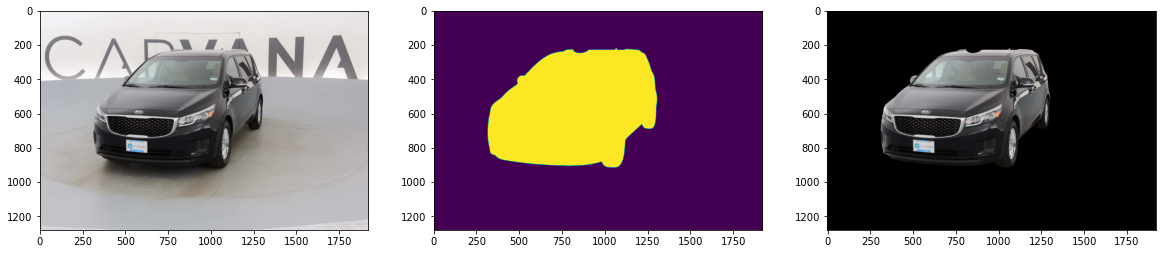

In [11]:
show_random()

Image shape: (1280, 1918, 3) | image type: uint8 | mask shape: (1280, 1918) | mask type: uint8


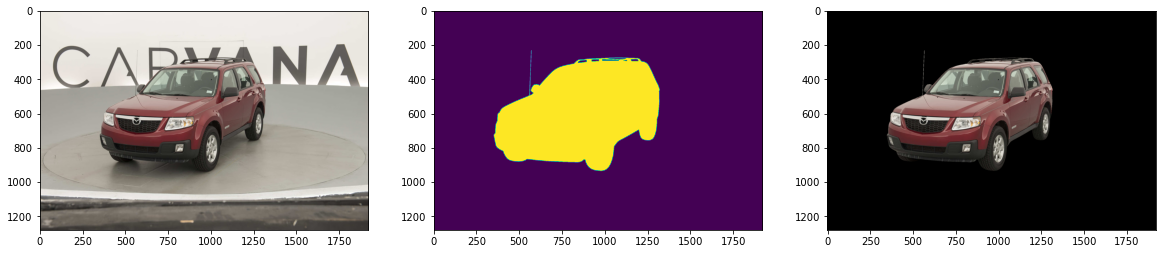

In [12]:
show_random()

# Take a look at car models in train set and test set

train set first

In [27]:
from collections import Counter

METADATA_CSV.index = METADATA_CSV['id']
train_metadata_csv = METADATA_CSV.loc[TRAIN_MASKS_CSV['id'].unique(),:]

In [37]:
# Seperate make count from the csv file, make it as a seperate df// for TRAIN set
train_make = pd.DataFrame.from_dict(dict(Counter(train_metadata_csv.make)),orient='index')\
            .reset_index().rename(columns = {'index':'make',0:'make_count'})

In [44]:
test_dataset_ids = list(set(METADATA_CSV['id']) - set(TRAIN_MASKS_CSV['id']))
test_metadata_csv = METADATA_CSV.loc[test_dataset_ids,:]

# Seperate make count from the csv file, make it as a seperate df// for TEST set
test_make = pd.DataFrame.from_dict(dict(Counter(test_metadata_csv.make)),orient='index')\
            .reset_index().rename(columns = {'index':'make',0:'make_count'})

In [47]:
# Merge both train and test set so that both plots have the same y axis
# How = right because test set has more makes than train set
joint_train_test_make = train_make.merge(test_make, how = 'right',on='make')

In [52]:
joint_train_test_make.head()

,make,make_count_x,make_count_y
0,Acura,12.0,111
1,Nissan,3.0,494
2,Chevrolet,27.0,543
3,Jaguar,5.0,14
4,Cadillac,13.0,144


In [51]:
# Fillna for df, prepare to plot
joint_train_test_make.make = joint_train_test_make.make.fillna("Unknown")
joint_train_test_make.make_count_x = joint_train_test_make.make_count_x.fillna(0)
joint_train_test_make.make_count_y = joint_train_test_make.make_count_y.fillna(0)

Text(0.5, 1.0, 'Car Make in Train set')

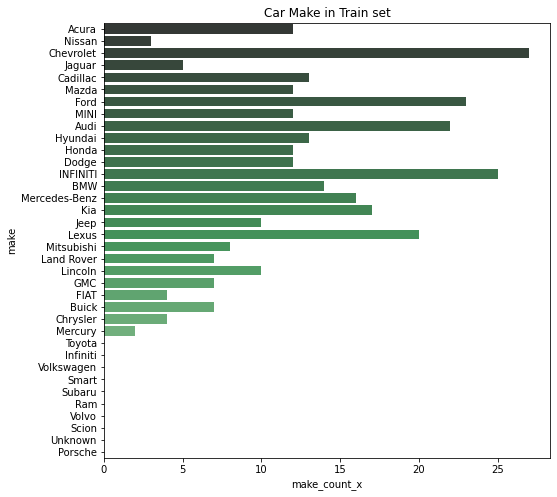

In [56]:
import seaborn as sns
# plot with seaborn
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x='make_count_x',y="make", data=joint_train_test_make, palette="Greens_d",ax=ax)
plt.title('Car Make in Train set')

Text(0.5, 1.0, 'Car Make in Test set')

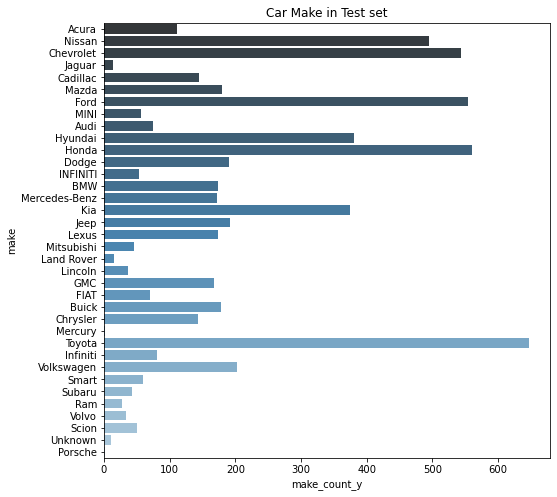

In [57]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x='make_count_y',y="make", data=joint_train_test_make, palette="Blues_d",ax=ax)
plt.title('Car Make in Test set')

We observed that there are models in the test set that never appears in train set.

We may need to pay more attention to those cars